In [6]:
# libraries
import os
import sys
import json
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../../extra_files'))
import helper as hp
from imageio import imwrite, imread
from skimage.transform import resize

In [7]:
# File paths
data_path = '/home/aldo/Documents/data-cic/'
preprocess_path = data_path + 'preprocess_data'

## Training SSD300 trained with mobilenet backbone trained

In [8]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from light_models.keras_ssd300_mobilenetv2 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from extra_files.f1_callback import F1_callback as f1_call

### Parameters (original SSD300 architecture)

In [9]:
## Parameteres needed for ssd_300() and SSDInputEncoder()

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [1., 1., 1.] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
divide_by_stddev = [127.5, 127.5, 127.5]
swap_channels = False # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales = scales_pascal
#scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [16, 30, 60, 100, 150, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

## Create new model with SSD weights

In [10]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                alpha=1.0,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

# 2: Load some weights into the model.

# TODO: Set the path to the weights you want to load.

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001)
#sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_stddev_normalization (Lam (None, 300, 300, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           input_stddev_normalization[0][0] 
__________________________________________________________________________________________________
model_1 (M

## Data generator for the training

In [7]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = data_path + 'PASCAL'
#images_dir = data_path + 'COCO'

# Ground truth
#train_labels_filename = preprocess_path + '/PASCAL_train.csv'
train_labels_filename = preprocess_path + '/PASCAL_train_val.csv'
val_labels_filename   = preprocess_path + '/PASCAL_val.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(#images_dir=images_dir,
                      data_path + 'PASCAL',
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading images into memory: 100%|██████████| 1025/1025 [00:04<00:00, 247.81it/s]
Number of images in the training dataset:	  6469
Number of images in the validation dataset:	  1025


In [8]:
# 3: Set the batch size.
batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.
# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.
# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv13_mbox_conf').output_shape[1:3],
                   model.get_layer('conv17_mbox_conf').output_shape[1:3],
                   model.get_layer('conv18_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv19_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv20_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv21_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	  6469
Number of images in the validation dataset:	  1025


## Remaining training parameters

In [9]:
# Define a learning rate schedule.
def lr_schedule(epoch):
    if epoch < 60:
        return 0.0001
    elif epoch < 70:
        return 0.00001
    else:
        return 0.000001

In [10]:
lr_list = [0.01, 0.001, 0.0001]

for lr in lr_list:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH LEARNING RATE:', lr)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                alpha=1.0,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=lr)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Downloads/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'model_' + str(lr) + '.csv',
                           separator=',',
                           append=True)


    f1_callback = f1_call(0.20, 
                           0.45, 
                           200, 
                           normalize_coords, 
                           img_height, 
                           img_width, 
                           (1, 2006, 14),
                           main_path + 'f1_' + str(lr) + '.csv',
                           main_path + 'model.h5',
                           label_csv='/home/aldo/Documents/data-cic/preprocess_data/PASCAL_val.csv',
                           path_img='/home/aldo/Documents/data-cic/PASCAL',
                           verborse=True)


    callbacks = [csv_logger,
                 f1_callback]
    
    initial_epoch   = 0
    final_epoch     = 100
    steps_per_epoch = 200

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  validation_data=val_generator,
                                  validation_steps=ceil(val_dataset_size/batch_size),
                                  initial_epoch=initial_epoch)

TRAINING MODEL WITH LEARNING RATE: 0.01
Epoch 1/100
200/200 [==============================] - 120s 599ms/step - loss: 121.0878 - val_loss: 147.1752


/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:383: RuntimeWarning: invalid value encountered in true_divide
  return intersection_areas / union_areas
/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:91: RuntimeWarning: invalid value encountered in less_equal
  boxes_left = boxes_left[similarities <= iou_threshold] # ...so that we can remove the ones that overlap too much with the maximum box


Number of images: 1025
Presicion: 0.014
Recall: 0.2036
F1 score: 0.0261
F1 score: 0.026141397828356353
Improve F1 score from -inf to 0.026141397828356353
Epoch 2/100
200/200 [==============================] - 108s 540ms/step - loss: 106.5339 - val_loss: 104.7687
Number of images: 1025
Presicion: 0.0167
Recall: 0.1795
F1 score: 0.0305
F1 score: 0.030530054100235793
Improve F1 score from 0.026141397828356353 to 0.030530054100235793
Epoch 3/100
200/200 [==============================] - 109s 545ms/step - loss: 107.0733 - val_loss: 106.8845
Number of images: 1025
Presicion: 0.0466
Recall: 0.3763
F1 score: 0.0829
F1 score: 0.082854360386477
Improve F1 score from 0.030530054100235793 to 0.082854360386477
Epoch 4/100
200/200 [==============================] - 110s 550ms/step - loss: 106.4365 - val_loss: 105.2696
Number of images: 1025
Presicion: 0.0512
Recall: 0.3688
F1 score: 0.0899
F1 score: 0.08993633157572349
Improve F1 score from 0.082854360386477 to 0.08993633157572349
Epoch 5/100
200/2

/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:175: RuntimeWarning: overflow encountered in exp
  y_pred_decoded_raw[:,:,[-2,-1]] = np.exp(y_pred_decoded_raw[:,:,[-2,-1]] * y_pred[:,:,[-2,-1]]) # exp(ln(w(pred)/w(anchor)) / w_variance * w_variance) == w(pred) / w(anchor), exp(ln(h(pred)/h(anchor)) / h_variance * h_variance) == h(pred) / h(anchor)
/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:198: RuntimeWarning: overflow encountered in multiply
  y_pred_decoded_raw[:,:,[-3,-1]] *= img_height # Convert ymin, ymax back to absolute coordinates
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:280: RuntimeWarning: overflow encountered in multiply
  return side_lengths[:,0] * side_lengths[:,1]
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:280: RuntimeWarning: invalid value encountered in multiply
  return side_lengths[:,0] * side_lengths[:,1]
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:378: Ru

Number of images: 1025
Presicion: 0.0781
Recall: 0.3326
F1 score: 0.1265
F1 score: 0.12649012658491174
Improve F1 score from 0.08993633157572349 to 0.12649012658491174
Epoch 8/100
200/200 [==============================] - 107s 535ms/step - loss: 141.9374 - val_loss: 674.0578
Number of images: 1025
Presicion: 0.0025
Recall: 0.05
F1 score: 0.0047
F1 score: 0.004684521543988075
Epoch 9/100
200/200 [==============================] - 106s 528ms/step - loss: 107.0604 - val_loss: 355.3525
Number of images: 1025
Presicion: 0.0
Recall: 0.0
F1 score: 0.0
F1 score: 3.3329545607589186e-20
Epoch 10/100
200/200 [==============================] - 107s 536ms/step - loss: 110.8243 - val_loss: 247.0752


/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:197: RuntimeWarning: overflow encountered in multiply
  y_pred_decoded_raw[:,:,[-4,-2]] *= img_width # Convert xmin, xmax back to absolute coordinates
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:378: RuntimeWarning: overflow encountered in subtract
  boxes1_areas = (boxes1[:,xmax] - boxes1[:,xmin] + d) * (boxes1[:,ymax] - boxes1[:,ymin] + d)
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:278: RuntimeWarning: overflow encountered in subtract
  side_lengths = np.maximum(0, max_xy - min_xy + d)


Number of images: 1025
Presicion: 0.0176
Recall: 0.1507
F1 score: 0.0316
F1 score: 0.031560911419670365
Epoch 11/100
200/200 [==============================] - 107s 534ms/step - loss: 107.3175 - val_loss: 131.6135
Number of images: 1025
Presicion: 0.0202
Recall: 0.2503
F1 score: 0.0373
F1 score: 0.03732554693540373
Epoch 12/100
200/200 [==============================] - 105s 525ms/step - loss: 107.5767 - val_loss: 114.5521
Number of images: 1025
Presicion: 0.0279
Recall: 0.2783
F1 score: 0.0507
F1 score: 0.050691611586901664
Epoch 13/100
200/200 [==============================] - 106s 529ms/step - loss: 106.9012 - val_loss: 109.4707
Number of images: 1025
Presicion: 0.007
Recall: 0.1264
F1 score: 0.0133
F1 score: 0.013250548746538663
Epoch 14/100
200/200 [==============================] - 107s 534ms/step - loss: 106.7656 - val_loss: 107.2442
Number of images: 1025
Presicion: 0.0219
Recall: 0.1835
F1 score: 0.0392
F1 score: 0.039181950563293766
Epoch 15/100
200/200 [====================

200/200 [==============================] - 107s 534ms/step - loss: 110.0127 - val_loss: 114.9576
Number of images: 1025
Presicion: 0.0038
Recall: 0.131
F1 score: 0.0074
F1 score: 0.00738637660510511
Epoch 50/100
200/200 [==============================] - 107s 536ms/step - loss: 107.3207 - val_loss: 107.5272
Number of images: 1025
Presicion: 0.0189
Recall: 0.1696
F1 score: 0.0339
F1 score: 0.03393428674870412
Epoch 51/100
200/200 [==============================] - 105s 525ms/step - loss: 107.2101 - val_loss: 107.4421
Number of images: 1025
Presicion: 0.0211
Recall: 0.1825
F1 score: 0.0378
F1 score: 0.03784822597473549
Epoch 52/100
200/200 [==============================] - 106s 531ms/step - loss: 106.6956 - val_loss: 106.7352
Number of images: 1025
Presicion: 0.0187
Recall: 0.1459
F1 score: 0.0331
F1 score: 0.03310846216996071
Epoch 53/100
200/200 [==============================] - 106s 528ms/step - loss: 106.6061 - val_loss: 106.6400
Number of images: 1025
Presicion: 0.0188
Recall: 0.1

200/200 [==============================] - 106s 530ms/step - loss: 106.6794 - val_loss: 107.6199
Number of images: 1025
Presicion: 0.0089
Recall: 0.0987
F1 score: 0.0164
F1 score: 0.016402103176928452
Epoch 89/100
200/200 [==============================] - 106s 532ms/step - loss: 106.8647 - val_loss: 107.3695
Number of images: 1025
Presicion: 0.0234
Recall: 0.2504
F1 score: 0.0428
F1 score: 0.04279071541376841
Epoch 90/100
200/200 [==============================] - 106s 532ms/step - loss: 106.8628 - val_loss: 106.8980
Number of images: 1025
Presicion: 0.0185
Recall: 0.2078
F1 score: 0.034
F1 score: 0.034004291422040325
Epoch 91/100
200/200 [==============================] - 106s 528ms/step - loss: 106.6832 - val_loss: 106.6519
Number of images: 1025
Presicion: 0.0221
Recall: 0.2185
F1 score: 0.0402
F1 score: 0.04022115204243692
Epoch 92/100
200/200 [==============================] - 105s 527ms/step - loss: 106.7872 - val_loss: 106.7853
Number of images: 1025
Presicion: 0.024
Recall: 0.

200/200 [==============================] - 106s 531ms/step - loss: 4.3345 - val_loss: 5.1377
Number of images: 1025
Presicion: 0.0538
Recall: 0.5267
F1 score: 0.0976
F1 score: 0.09757579263602506
Epoch 27/100
200/200 [==============================] - 123s 615ms/step - loss: 4.3833 - val_loss: 4.6787
Number of images: 1025
Presicion: 0.0534
Recall: 0.5034
F1 score: 0.0966
F1 score: 0.09662546083699186
Epoch 28/100
200/200 [==============================] - 113s 565ms/step - loss: 4.2961 - val_loss: 5.0407
Number of images: 1025
Presicion: 0.0457
Recall: 0.4865
F1 score: 0.0836
F1 score: 0.08355357714342539
Epoch 29/100
200/200 [==============================] - 107s 534ms/step - loss: 4.2923 - val_loss: 5.4725
Number of images: 1025
Presicion: 0.0441
Recall: 0.5051
F1 score: 0.0811
F1 score: 0.0810952926340034
Epoch 30/100
200/200 [==============================] - 106s 531ms/step - loss: 4.3035 - val_loss: 4.8378
Number of images: 1025
Presicion: 0.0392
Recall: 0.5063
F1 score: 0.0727

Epoch 4/100
200/200 [==============================] - 106s 529ms/step - loss: 5.4428 - val_loss: 6.6102
Number of images: 1025
Presicion: 0.0509
Recall: 0.399
F1 score: 0.0902
F1 score: 0.09023404077567851
Improve F1 score from 0.07974811843807493 to 0.09023404077567851
Epoch 5/100
200/200 [==============================] - 106s 531ms/step - loss: 5.3199 - val_loss: 6.5248
Number of images: 1025
Presicion: 0.0535
Recall: 0.4098
F1 score: 0.0947
F1 score: 0.09472152702012492
Improve F1 score from 0.09023404077567851 to 0.09472152702012492
Epoch 6/100
200/200 [==============================] - 107s 533ms/step - loss: 5.2171 - val_loss: 6.0504
Number of images: 1025
Presicion: 0.0539
Recall: 0.4326
F1 score: 0.0958
F1 score: 0.09581827522585497
Improve F1 score from 0.09472152702012492 to 0.09581827522585497
Epoch 7/100
200/200 [==============================] - 107s 536ms/step - loss: 5.1156 - val_loss: 5.5107
Number of images: 1025
Presicion: 0.0529
Recall: 0.4475
F1 score: 0.0946
F1 s

200/200 [==============================] - 107s 535ms/step - loss: 3.9610 - val_loss: 4.1091
Number of images: 1025
Presicion: 0.0712
Recall: 0.5149
F1 score: 0.1251
F1 score: 0.1251120388085739
Epoch 79/100
200/200 [==============================] - 105s 527ms/step - loss: 3.9695 - val_loss: 4.0817
Number of images: 1025
Presicion: 0.1438
Recall: 0.4767
F1 score: 0.221
F1 score: 0.22098711577110342
Epoch 80/100
200/200 [==============================] - 106s 532ms/step - loss: 3.9283 - val_loss: 4.0608
Number of images: 1025
Presicion: 0.1025
Recall: 0.4905
F1 score: 0.1696
F1 score: 0.16956882800436818
Epoch 81/100
200/200 [==============================] - 107s 533ms/step - loss: 3.9719 - val_loss: 4.0711
Number of images: 1025
Presicion: 0.1226
Recall: 0.486
F1 score: 0.1958
F1 score: 0.19583348926588234
Epoch 82/100
200/200 [==============================] - 106s 532ms/step - loss: 3.9585 - val_loss: 4.1636
Number of images: 1025
Presicion: 0.1271
Recall: 0.4903
F1 score: 0.2019
F

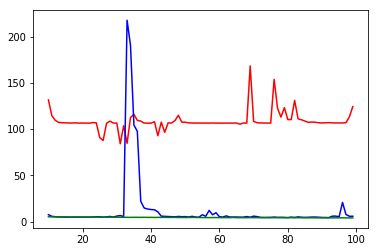

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
mob_01 = pd.read_csv(main_path + 'model_0.01.csv')
mob_001 = pd.read_csv(main_path + 'model_0.001.csv')
mob_0001 = pd.read_csv(main_path + 'model_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01['epoch'][10:], mob_01['val_loss'][10:], color='r')
ax.plot(mob_001['epoch'][10:], mob_001['val_loss'][10:], color='b')
ax.plot(mob_0001['epoch'][10:], mob_0001['val_loss'][10:], color='g')

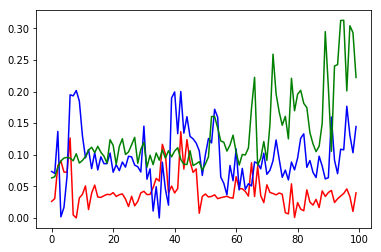

In [13]:
mob_01_f1 = pd.read_csv(main_path + 'f1_0.01.csv')
mob_001_f1 = pd.read_csv(main_path + 'f1_0.001.csv')
mob_0001_f1 = pd.read_csv(main_path + 'f1_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01_f1['epoch'], mob_01_f1['f1 score'], color='r')
ax.plot(mob_001_f1['epoch'], mob_001_f1['f1 score'], color='b')
ax.plot(mob_0001_f1['epoch'], mob_0001_f1['f1 score'], color='g')

In [10]:
alphas = [1.0, 0.6, 0.25]

for alpha in alphas:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH ALPHA:', alpha)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                alpha=alpha,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=0.001)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Documents/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'data-cic/history/light_models/PASCAL/mobilenet_v2_alpha_' + str(alpha) + '.csv',
                           separator=',',
                           append=True)

    learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule, verbose=1)


    callbacks = [csv_logger,
                 learning_rate_scheduler]
    
    initial_epoch   = 0
    final_epoch     = 80
    steps_per_epoch = 1000

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  initial_epoch=initial_epoch)
    
    model.save(main_path + 'weights/light_models/PASCAL/mobilenet_v2_alpha_' + str(alpha) + '.h5')

TRAINING MODEL WITH ALPHA: 1.0
Epoch 1/80

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 567s 567ms/step - loss: 6.6649
Epoch 2/80

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 574s 574ms/step - loss: 5.1164
Epoch 3/80

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 564s 564ms/step - loss: 4.9450
Epoch 4/80

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 540s 540ms/step - loss: 4.8143
Epoch 5/80

Epoch 00005: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 545s 545ms/step - loss: 4.6769
Epoch 6/80

Epoch 00006: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 560s 560ms/step - loss: 4.6001
Epoch 7/80

Epoch 00007: Learning

1000/1000 [==============================] - 535s 535ms/step - loss: 3.3593
Epoch 54/80

Epoch 00054: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 535s 535ms/step - loss: 3.3270
Epoch 55/80

Epoch 00055: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 534s 534ms/step - loss: 3.3432
Epoch 56/80

Epoch 00056: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 538s 538ms/step - loss: 3.3386
Epoch 57/80

Epoch 00057: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 532s 532ms/step - loss: 3.3098
Epoch 58/80

Epoch 00058: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 533s 533ms/step - loss: 3.3137
Epoch 59/80

Epoch 00059: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 534s 534ms/st

1000/1000 [==============================] - 525s 525ms/step - loss: 3.3553
Epoch 78/80

Epoch 00078: LearningRateScheduler setting learning rate to 1e-06.
1000/1000 [==============================] - 529s 529ms/step - loss: 3.3528
Epoch 79/80

Epoch 00079: LearningRateScheduler setting learning rate to 1e-06.
1000/1000 [==============================] - 527s 527ms/step - loss: 3.3371
Epoch 80/80

Epoch 00080: LearningRateScheduler setting learning rate to 1e-06.
1000/1000 [==============================] - 529s 529ms/step - loss: 3.3401
TRAINING MODEL WITH ALPHA: 0.25
Epoch 1/80

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 532s 532ms/step - loss: 7.0223
Epoch 2/80

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 527s 527ms/step - loss: 5.5081
Epoch 3/80

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [=====================